In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from dataset import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
train_set = pd.read_csv('data/train_scaled.csv')
test_set = pd.read_csv('data/test_scaled.csv')

In [4]:
train_set.iloc[:,2:56].head()

,gender,age,elixhauser,re_admission,SOFA,SIRS,Weight_kg,GCS,HR,SysBP,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,sedation,mechvent,rrt
0,1.0,0.203388,0.000000,0.0,0.304348,0.25,0.183842,1.000000,0.556122,0.434485,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.177479,0.0,0.0,0.0
1,1.0,0.203388,0.000000,0.0,0.130435,0.50,0.183842,1.000000,0.476531,0.425294,...,0.0,0.0,0.000000,0.000000,0.616278,0.782139,0.175772,0.0,0.0,0.0
2,1.0,0.203388,0.000000,0.0,0.086957,0.50,0.183842,1.000000,0.470408,0.444512,...,0.0,0.0,0.000000,0.000000,0.659309,0.767260,0.174328,0.0,0.0,0.0
3,1.0,0.203388,0.000000,0.0,0.217391,0.50,0.183842,1.000000,0.545918,0.426130,...,0.0,0.0,0.000000,0.000000,0.659309,0.000000,0.174328,0.0,0.0,0.0
4,0.0,0.909010,0.142857,0.0,0.217391,0.50,0.204211,0.047619,0.342201,0.491183,...,0.0,0.0,0.632976,0.822795,0.570801,0.657302,0.179999,1.0,1.0,0.0


In [35]:
observ_cols = ['gender', 'age','elixhauser','re_admission', 'SOFA', 'SIRS', 'Weight_kg', 'GCS', 'HR',
                'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
                'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride',
                'Glucose', 'BUN', 'Creatinine', 'Magnesium', 'Calcium',
                'Ionised_Ca', 'CO2_mEqL', 'SGOT', 'SGPT', 'Total_bili',
                'Albumin', 'Hb', 'WBC_count', 'Platelets_count', 'PTT',
                'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2',
                'Arterial_BE', 'Arterial_lactate', 'HCO3', 'PaO2_FiO2',
                'output_total', 'output_4hourly']

In [36]:
def generate_dataset(train_dir='./data/train_scaled.csv', test_dir='./data/test_scaled.csv'):
	if not train_dir:
		data = pd.read_csv(test_dir)
	elif not test_dir:
		data = pd.read_csv(train_dir)
	else:
		train_data = pd.read_csv(train_dir)
		test_data = pd.read_csv(test_dir)
		data = train_data.append(test_data)
        
	features = data[observ_cols].values
	rewards = data['died_in_hosp'].values
	patients = data['icustayid'].values
	feature_names = observ_cols
	return features, rewards, feature_names, patients

    
class SepsisHospitalMortality(Dataset):
	def __init__(self, rwd=0, train_dir='./data/train_scaled.csv'):
		features, rewards, feature_names, uids = generate_dataset(train_dir=train_dir, test_dir=None)
        #determine all the indexes where the patient ID changes.
		split_points = (np.argwhere(uids[1:] - uids[:-1]) + 1)[:,0]
		idx_1 = np.argwhere(rewards == 1)[:,0]
		idx_0 = np.argwhere(rewards == 0)[:,0][:len(idx_1)]
        
		n = int(len(idx_1) * 0.8)
		n0 = next(i for i in range(n-5, n+20) if idx_0[i] in split_points)
		n1 = next(i for i in range(n-5, n+20) if idx_1[i] in split_points)
        
		# Now we have train and test indexes into the original array of features/labels
		idx_0_train = idx_0[:n0]
		idx_1_train = idx_1[:n1]
		idx_0_val = idx_0[n0:]
		idx_1_val = idx_1[n1:]
        
		idx_train = np.hstack((idx_0_train, idx_1_train))
		idx_val = np.hstack((idx_0_val, idx_1_val))

		np.random.shuffle(idx_train)
		np.random.shuffle(idx_val)
		self.idx_train = idx_train
		self.idx_val = idx_val
		self.features = features
		self.rewards = rewards #.reshape(-1, 1)
		self.feature_names = feature_names
		self.label_names = ['Survived', 'Died in Hospital']

	@property
	def X(self): return self.features[self.idx_train]
	@property
	def y(self): return self.rewards[self.idx_train]
	@property
	def Xv(self): return self.features[self.idx_val]
	@property
	def yv(self): return self.rewards[self.idx_val]


	def visualize_prediction_and_explanation(self, x, y, prob, grad):
		fig = plt.figure(figsize=(20, 8))
		G = gridspec.GridSpec(6, 10)

		mag = np.abs(grad).max()
		pred = int(round(prob))
		norm = Normalize(vmin=-1, vmax=1)
		sm = ScalarMappable(norm=norm, cmap=plt.cm.bwr)
		xmin = self.Xv.min(axis=0)
		xmax = self.Xv.max(axis=0)
		xmed = (xmin + xmax) * 0.5

		plt.subplot(G[:,:2])
		self.explanation_barchart(grad)
		plt.title('$\hat{y}='+str(pred)+'$')
		plt.gca().set_yticklabels(['{}: {:.2f}'.format(n, x[j]) for j,n in enumerate(self.feature_names)], fontsize=9)

		for i, label in enumerate(sorted(self.feature_names)):
			divisor = 1.0
			if label == 'age': divisor = 365.0
			j = self.feature_names.index(label)
			weight = (grad[j]/mag)**2 * np.sign(grad[j])
			plt.subplot(G[i//8, 2+i%8], axisbg=sm.to_rgba(weight))
			plt.hist(self.Xv[:,j]/divisor, bins=25, alpha=0.5, color='blue')
			plt.gca().set_yticklabels([])
			plt.axvline(x[j]/divisor, ls='--', lw=2, color='black')
			plt.tick_params(axis='both', which='major', labelsize=8)
			plt.xticks(np.array([xmin[j], xmed[j], xmax[j]])/divisor)
			plt.title(label[:16] + ": {:.1f}".format(x[j]/divisor), fontsize=8)

		fig.suptitle('Prediction = {} ({:.1%}), True Outcome = {}'.format(
				self.label_names[pred], prob,
				self.label_names[y]), fontsize=16)
		plt.tight_layout(rect=[0, 0.03, 1, 0.95])
		plt.show()

In [13]:
def kFoldCV(X, y, k=10, l1_penalty=0.01, **kw):
    mdls = []
    accs = []
    cv = StratifiedKFold(k, shuffle=True)
    for i, (train_idx, test_idx) in enumerate(cv.split(X, np.argmax(y, axis=1))):
        model = dataset.twolayer_mlp()
        Xt, Xv, yt, yv = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        l, a, lv, av = model.fit(Xt, yt, Xv, yv, l1=l1_penalty, **kw)
        mdls += [model]
        accs += [av]
        print('Fold:{}/{}, train_loss:{}, train_acc:{}, val_loss:{}, val_acc:{}'.format(i+1, k,\
                                                                                        l[-1], a[-1],\
                                                                                        lv, av))
    print ('{}-fold cv acc: {}'.format(k, np.mean(accs)))
    return mdls[np.argmax(accs)]

In [37]:
def plot_coefs_vs_features(self, grads, title='', log=True):
  from matplotlib.colors import LogNorm
  import matplotlib.pyplot as plt
  plt.figure(figsize=(14,8))

  plt.gcf().suptitle('Mortality Gradients vs. Feature Values{}'.format(title), y=1.03, fontsize=20)
  for i in range(self.Xv.shape[1]):
    plt.subplot(6,8,i+1)
    plt.title(observ_cols[i].replace('cumulated_balance_tev', 'cumul_bal'))
    if log:
        plt.hist2d(self.Xv[:,i], grads[:,i], bins=(10,5), norm=LogNorm())
    else:
        plt.hist2d(self.Xv[:,i], grads[:,i], bins=(10,5))
    lim = np.abs(grads).max()
    plt.ylim(-lim, lim)
    plt.axhline(0, color='white', ls='--', lw=2)
    plt.gca().set_yticks([])
  plt.tight_layout()
  plt.show()

In [10]:
dataset = SepsisHospitalMortality()

In [20]:
X, y = dataset.X, onehot(dataset.y)
Xv, yv = dataset.Xv, onehot(dataset.yv)
XX, yy = np.vstack((X, Xv)), np.vstack((y, yv))

cv_model = kFoldCV(XX, yy, k=10, l1_penalty=0.01, num_epochs=50, initial_learning_rate=0.01)

Epoch 1, loss 0.6013, accuracy 0.7422, 6.7s
Epoch 2, loss 0.5841, accuracy 0.7500, 7.2s
Epoch 3, loss 0.5817, accuracy 0.7578, 7.6s
Epoch 4, loss 0.5657, accuracy 0.7734, 8.2s
Epoch 5, loss 0.5671, accuracy 0.7656, 8.7s
Epoch 6, loss 0.5766, accuracy 0.7891, 9.2s
Epoch 7, loss 0.5810, accuracy 0.7578, 9.7s
Epoch 8, loss 0.5619, accuracy 0.7656, 10.1s
Epoch 9, loss 0.5753, accuracy 0.7812, 10.6s
Epoch 10, loss 0.5487, accuracy 0.7656, 11.0s
Epoch 11, loss 0.5607, accuracy 0.7812, 11.4s
Epoch 12, loss 0.5711, accuracy 0.7891, 11.9s
Epoch 13, loss 0.5774, accuracy 0.7656, 12.3s
Epoch 14, loss 0.5781, accuracy 0.7812, 12.7s
Epoch 15, loss 0.5724, accuracy 0.7578, 13.2s
Epoch 16, loss 0.5744, accuracy 0.7656, 13.7s
Epoch 17, loss 0.5874, accuracy 0.7422, 14.1s
Epoch 18, loss 0.5620, accuracy 0.7656, 14.5s
Epoch 19, loss 0.5715, accuracy 0.7500, 15.0s
Epoch 20, loss 0.5795, accuracy 0.7344, 15.4s
Epoch 21, loss 0.5758, accuracy 0.7500, 15.8s
Epoch 22, loss 0.5741, accuracy 0.7656, 16.3s
Epoc

Epoch 21, loss 0.5819, accuracy 0.7734, 15.1s
Epoch 22, loss 0.5491, accuracy 0.7734, 15.6s
Epoch 23, loss 0.5706, accuracy 0.7812, 16.0s
Epoch 24, loss 0.5582, accuracy 0.7891, 16.4s
Epoch 25, loss 0.5654, accuracy 0.7734, 16.9s
Epoch 26, loss 0.5553, accuracy 0.7969, 17.3s
Epoch 27, loss 0.5576, accuracy 0.7891, 17.7s
Epoch 28, loss 0.5586, accuracy 0.7812, 18.2s
Epoch 29, loss 0.5598, accuracy 0.7891, 18.6s
Epoch 30, loss 0.5634, accuracy 0.7891, 19.0s
Epoch 31, loss 0.5579, accuracy 0.7734, 19.5s
Epoch 32, loss 0.5600, accuracy 0.7578, 19.9s
Epoch 33, loss 0.5690, accuracy 0.7812, 20.3s
Epoch 34, loss 0.5564, accuracy 0.7812, 20.8s
Epoch 35, loss 0.5768, accuracy 0.7500, 21.2s
Epoch 36, loss 0.5488, accuracy 0.7656, 21.7s
Epoch 37, loss 0.5525, accuracy 0.7656, 22.1s
Epoch 38, loss 0.5480, accuracy 0.7734, 22.5s
Epoch 39, loss 0.5680, accuracy 0.7500, 23.0s
Epoch 40, loss 0.5681, accuracy 0.7500, 23.4s
Epoch 41, loss 0.5677, accuracy 0.7734, 23.8s
Epoch 42, loss 0.5606, accuracy 0.

Epoch 40, loss 0.5382, accuracy 0.7891, 24.0s
Epoch 41, loss 0.5653, accuracy 0.7812, 24.5s
Epoch 42, loss 0.5456, accuracy 0.8047, 24.9s
Epoch 43, loss 0.5364, accuracy 0.7656, 25.4s
Epoch 44, loss 0.5536, accuracy 0.7891, 25.8s
Epoch 45, loss 0.5387, accuracy 0.7891, 26.2s
Epoch 46, loss 0.5436, accuracy 0.7969, 26.7s
Epoch 47, loss 0.5572, accuracy 0.7891, 27.2s
Epoch 48, loss 0.5368, accuracy 0.7969, 27.7s
Epoch 49, loss 0.5398, accuracy 0.7891, 28.3s
Epoch 50, loss 0.5531, accuracy 0.7969, 28.7s
Val: epoch 50, loss 0.5884, accuracy 0.7255
Fold:7/10, train_loss:0.5530641078948975, train_acc:0.796875, val_loss:0.5883943438529968, val_acc:0.7255393862724304
Epoch 1, loss 0.5914, accuracy 0.7578, 7.1s
Epoch 2, loss 0.5883, accuracy 0.7500, 7.5s
Epoch 3, loss 0.5954, accuracy 0.7500, 8.0s
Epoch 4, loss 0.5878, accuracy 0.7578, 8.5s
Epoch 5, loss 0.5898, accuracy 0.7500, 8.9s
Epoch 6, loss 0.5809, accuracy 0.7656, 9.3s
Epoch 7, loss 0.5802, accuracy 0.7422, 9.8s
Epoch 8, loss 0.5951, ac

In [21]:
new_grads = cv_model.input_gradients(dataset.Xv, y=0, logits=True)

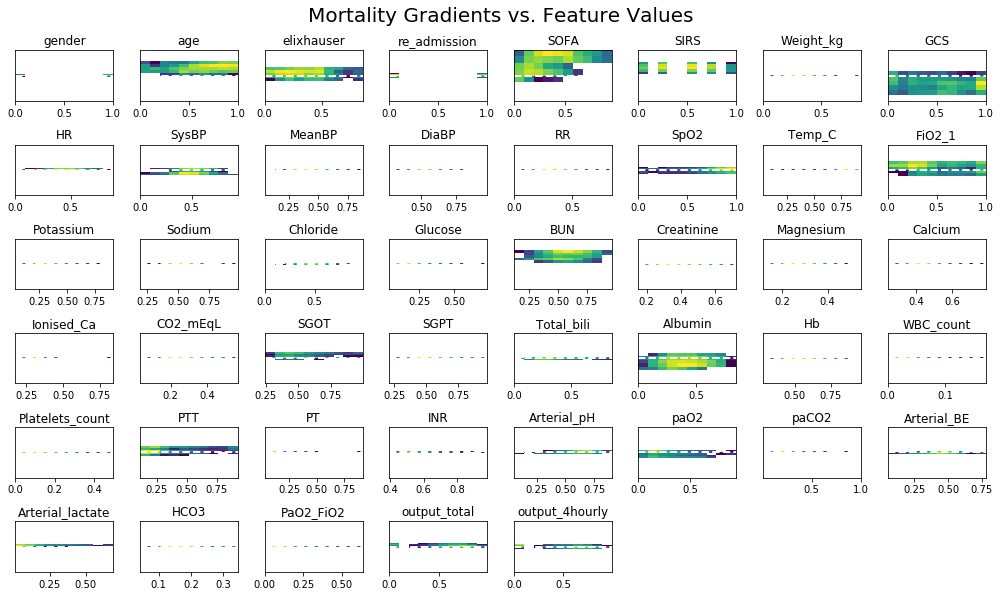

In [38]:
plot_coefs_vs_features(dataset, new_grads)

Mortality log-odds


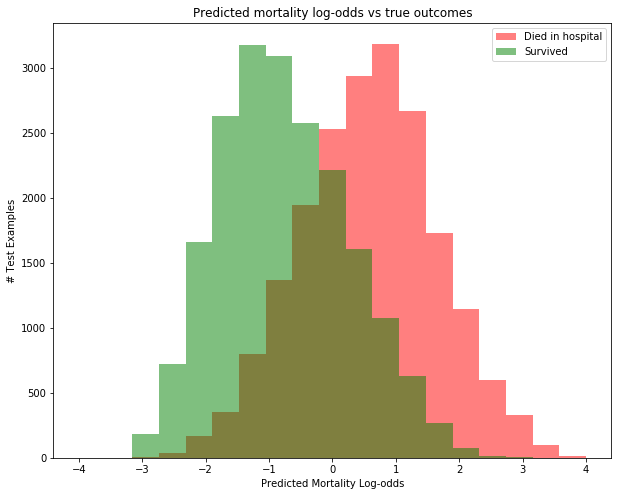

In [23]:
yyy = np.argmax(yy, axis=1) # not one-hot encoded
mort_true = np.argwhere(yyy == 1)[:,0]
mort_false = np.argwhere(yyy == 0)[:,0]

plt.figure(figsize = (10, 8))
print('Mortality log-odds')
predicted_mortality_logodds = cv_model.predict_binary_logodds(XX)
bins = np.linspace(-4, 4, 20)
plt.hist(
    predicted_mortality_logodds[mort_true],
    alpha=0.5, label='Died in hospital',
    color='red', bins=bins)
plt.hist(
    predicted_mortality_logodds[mort_false],
    alpha=0.5, label='Survived',
    color='green', bins=bins)

plt.ylabel('# Test Examples')
plt.xlabel('Predicted Mortality Log-odds')
plt.legend(loc='best')
plt.title('Predicted mortality log-odds vs true outcomes')
plt.show()